# Assignment 6

In [116]:
# Importing Libraries 
import numpy as np
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
import os, glob
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns

#### Creating the dataset

In [117]:
image_size = (64,64)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        '../data/dataset_train/',
        target_size=image_size,
        batch_size=32,
        class_mode='categorical')

Found 88 images belonging to 4 classes.


#### Creating the classifier object

In [118]:
def create_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(64,64,3,)))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(filters=64,kernel_size = (3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Flatten())
    model.add(Dense(units=4,activation='softmax'))
    model.compile(
                loss='categorical_crossentropy', 
                metrics=['acc'],
                optimizer='adam'
                )
    return model
classifier = create_model()
classifier.summary()

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_252 (Conv2D)         (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_252 (MaxPooli  (None, 31, 31, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_253 (Conv2D)         (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_253 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                           
                                                                 
 flatten_126 (Flatten)       (None, 12544)             0         
                                                                 
 dense_126 (Dense)           (None, 4)              

#### Fitting to the classifier

In [119]:
output = classifier.fit(train_generator,epochs=3,steps_per_epoch=3)

Epoch 1/3
3/3 [==============================] - 1s 140ms/step - loss: 1.3444 - acc: 0.5114
Epoch 2/3
3/3 [==============================] - 0s 162ms/step - loss: 0.9624 - acc: 0.5568
Epoch 3/3
3/3 [==============================] - 0s 146ms/step - loss: 0.6637 - acc: 0.8750


In [120]:
output.history

{'loss': [1.344425082206726, 0.9624254107475281, 0.6636754870414734],
 'acc': [0.5113636255264282, 0.5568181872367859, 0.875]}

In [121]:
classifier.save('my_model.h5')

#### Hyper Parameter Tuning

In [122]:
img_dir = r'../data/dataset_test/'
val_ds = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  image_size=image_size,
  labels=None,
  shuffle=False,
  batch_size=32)

Found 8 files belonging to 1 classes.


Using batch Size of 8 to avoid warnings.

In [123]:
image_size = (64,64)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        '../data/dataset_train/',
        target_size=image_size,
        batch_size=8,
        class_mode='categorical')

Found 88 images belonging to 4 classes.


In [124]:
correct_outputs = np.array([0,0,2,2,1,1,3,3])
parameters = [(1,1),(1,2),(1,3),(2,4),(2,5),(2,6),(3,3),(3,7),(3,8),(5,9),(5,10)]
batch_size = 32
output_df = pd.DataFrame(columns=['Steps per Epoch','Epochs','Test Accuracy','Train Loss','Train Accuracy'])
for i,j in parameters:
    model = create_model()
    output = model.fit(train_generator,epochs=j,steps_per_epoch=i,verbose=0)
    history = output.history
    predicted = model.predict(val_ds).round()
    predicted = np.where(predicted == 1)
    accuracy = accuracy_score(correct_outputs,predicted[1])
    temp = pd.DataFrame({'Steps per Epoch':[i],'Epochs':[j],'Test Accuracy':[accuracy],'Train Loss':[history['loss'][-1]],'Train Accuracy':[history['acc'][-1]]})
    output_df = pd.concat([output_df,temp])

1/1 [==============================] - 0s 46ms/step


In [125]:
output_df = output_df.set_index(np.arange(0,len(output_df)))
output_df

,Steps per Epoch,Epochs,Test Accuracy,Train Loss,Train Accuracy
0,1,1,0.250,1.274417,0.500000
1,1,2,0.250,1.778443,0.000000
2,1,3,0.375,1.431064,0.500000
3,2,4,0.500,0.899925,0.812500
4,2,5,0.500,0.906547,0.687500
5,2,6,0.625,0.691201,0.875000
6,3,3,0.625,1.131898,0.291667
7,3,7,0.875,0.418862,0.958333
8,3,8,0.750,0.187093,1.000000
9,5,9,0.750,0.162055,0.950000


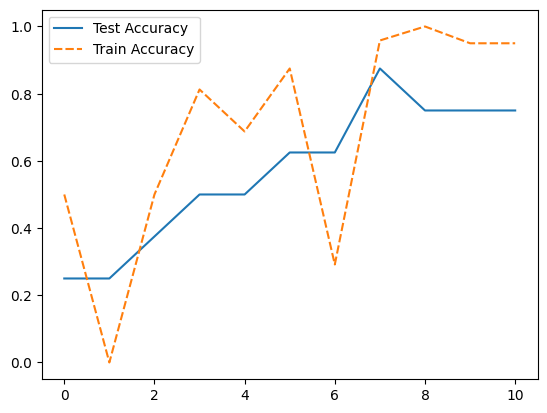

In [126]:
lineplot = sns.lineplot(data=output_df[['Test Accuracy','Train Accuracy']])

## Conceptual Questions: 

#### 4.Discuss the effect of the following on accuracy and loss (train & test): 

1. Increasing the steps_per_epoch
2. Increasing the number of epochs

Increasing the steps_per_epoch will likely increase the accuracy of the model, but it may not necessarily reduce the loss. steps_per_epoch determines the number of batches of data that are processed per epoch. By increasing steps_per_epoch, the model gets to see more data, and this can lead to better accuracy since the model is trained on more samples. However, if the model is not complex enough or if the data is noisy, increasing steps_per_epoch may not improve accuracy and may instead lead to overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data.

Increasing the number of epochs, on the other hand, can also increase the accuracy of the model, but it may also increase the loss. An epoch refers to one iteration over the entire training dataset. By increasing the number of epochs, the model has more opportunities to learn from the data and fine-tune its parameters, which can lead to better accuracy. However, if the model is not able to generalize well to new data, increasing the number of epochs can lead to overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data.

It's important to note that the effect of these hyperparameters (steps_per_epoch and number of epochs) on accuracy and loss will also depend on other factors such as the complexity of the model, the quality and size of the dataset, and the optimization algorithm used. Therefore, it's crucial to carefully tune these hyperparameters to find the best combination for a given problem.

#### 5.Name two uses of zero padding in CNN.

Zero padding is a technique used in Convolutional Neural Networks (CNNs) to add extra rows and columns of zeros to the input volume's borders. Two main uses of zero padding in CNNs are:

1. Keeping the spatial dimensions: By using zero padding, we can preserve the spatial dimensions of the input volume, even after applying multiple convolutional and pooling layers. Without zero padding, each convolutional or pooling layer would reduce the size of the output volume, which can be problematic when working with small input volumes. Zero padding allows us to maintain the spatial dimensions of the input volume while still applying the necessary number of convolutional and pooling layers.
2. Improved edge detection: Zero-padding can be used to improve edge detection by reducing the loss of information at the edges of an image. When convolving an image with a filter kernel, the edge pixels of the image are only partially covered by the kernel, resulting in the loss of information at the edges. By adding zero-padding around the input image, the edge pixels of the image are fully covered by the kernel, thus reducing the loss of information at the edges and improving the accuracy of edge detection.

#### 6.What is the use of a 1 x 1 kernel in CNN? 

A 1 x 1 kernel is a filter of size 1 x 1 used in convolutional neural networks (CNNs). It may seem counterintuitive to use such a small kernel, but it has several important uses in CNNs, including:

1. Dimensionality reduction: By using a 1 x 1 convolutional layer, the number of channels in the input feature map can be reduced without changing the spatial dimensions. This is useful when the input feature map is too large or too computationally expensive to process in subsequent layers.

2. Non-linearity: Although a 1 x 1 convolutional layer only has one parameter, it can still introduce non-linearity into the network, which can be important for learning complex features.

3. Network fusion: Multiple 1 x 1 convolutional layers can be used in parallel to combine information from different feature maps or layers. This technique is known as network fusion and can improve the accuracy of the model by allowing it to learn more complex features.

4. Regularization: By adding a 1 x 1 convolutional layer with a small number of filters (e.g., 32 or 64), the model can be regularized by reducing the number of parameters and preventing overfitting.

#### 7.What are the advantages of a CNN over a fully connected DNN for this image classification problem?

Convolutional neural networks (CNNs) are specifically designed for image classification tasks, and they have several advantages over fully connected deep neural networks (DNNs) for this problem. Here are some advantages of CNNs:

1. Parameter sharing: CNNs use convolutional layers to scan the input image with multiple filters or kernels, and each filter is used to detect a specific feature in the image. By sharing parameters across the filters, CNNs can learn to detect different features at different locations in the image, while greatly reducing the number of parameters compared to a fully connected DNN.

2. Translation invariance: Convolutional layers are designed to be translation-invariant, which means that they can detect the same features in different parts of the image, regardless of their location. This is important for image classification tasks, as the same object can appear in different parts of the image.

3. Reduced overfitting: CNNs are less prone to overfitting compared to fully connected DNNs because of the use of pooling layers and dropout layers. Pooling layers help to reduce the spatial dimensions of the feature maps, which can reduce the number of parameters and prevent overfitting. Dropout layers randomly drop out some of the neurons during training, which helps to prevent overfitting by reducing the co-adaptation of neurons.

4. Hierarchical feature learning: CNNs use multiple convolutional layers and pooling layers to learn hierarchical features from the input image. The first few layers learn low-level fea4. tures such as edges and corners, while the later layers learn high-level features such as object parts and shapes.